<a href="https://colab.research.google.com/github/mrzResearchArena/TF-2.x/blob/master/Save-Load-Log-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# !nvidia-smi
# !free -h
# !sudo dmidecode --type 17 
# !cat /proc/cpuinfo | grep 'model name'
# import multiprocessing
# multiprocessing.cpu_count()

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd 'drive/My Drive/HC-PyFeat'

/content/drive/My Drive/HC-PyFeat


In [ ]:
ls

acp240.npy     matrix8.npy                    ModelStash.data-00000-of-00001
acp740.npy     model-HC.png                   ModelStash.index
acp740.pickle  ModelLSTM/                     pg11-48.npy
checkpoint     ModelLSTM.data-00000-of-00001  pg.npy
D.npy          ModelLSTM.index                pkmer-64.npy
D.pickle       ModelSave/                     X.npy
HC.txt         ModelSave.data-00000-of-00001
log.csv        ModelSave.index


In [ ]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# NLP:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)
from sklearn.utils import shuffle

#end-import

We're using TF-2.3.0.


In [ ]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

In [ ]:
# T = 125 # terminus_length

import pickle
with open('acp740.pickle', 'rb') as file:   #Pickling
    X = pickle.load(file)

Y  = [1 for _ in range(376)]
Y += [0 for _ in range(364)]
Y  = np.array(Y) 
# Y = labelEncoding(Y, dtype=int)


# print(X.shape)
print(Y.shape)

(740,)


In [ ]:
len(X[0])

486

In [ ]:
# split up the data
X, Y = shuffle(X, Y, random_state = 101)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.75)

In [ ]:
len(Xtrain)

555

In [ ]:
MAX_VOCAB_SIZE = 65000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(Xtrain)

sequences_train = tokenizer.texts_to_sequences(Xtrain)
sequences_test = tokenizer.texts_to_sequences(Xtest)

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 61350 unique tokens.


In [ ]:
# pad sequences so that we get a N x T matrix
Xtrain = pad_sequences(sequences_train, padding='post')
print('Shape of data train tensor:', Xtrain.shape)

# get sequence length
T = Xtrain.shape[1]

Shape of data train tensor: (555, 1557)


In [ ]:
Xtest = pad_sequences(sequences_test, maxlen=T, padding='post')
print('Shape of data test tensor:', Xtest.shape)

Shape of data test tensor: (185, 1557)


In [ ]:
Xtrain.shape

(555, 1557)

In [ ]:
# Create the model
def Network():
    # We get to choose embedding dimensionality
    D = 300

    # Hidden state dimensionality
    M = 150

    # Note: we actually want to the size of the embedding to (V + 1) x D,
    # because the first index starts from 1 and not 0.
    # Thus, if the final index of the embedding matrix is V,
    # then it actually must have size V + 1.

    i = Input(shape=(T,))
    x = Embedding(V + 1, D)(i)

    # x = LSTM(M, return_sequences=True)(x)
    # x = GlobalMaxPooling1D()(x)

    x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)    
    # x = Dropout(rate=0.80)(x)

    x = Dense(1, activation='sigmoid')(x)

    return Model(i, x)
#end-def

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1557)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1557, 300)         18405300  
_________________________________________________________________
conv1d (Conv1D)              (None, 1555, 32)          28832     
_________________________________________________________________
batch_normalization (BatchNo (None, 1555, 32)          128       
_________________________________________________________________
dense (Dense)                (None, 1555, 1)           33        
Total params: 18,434,293
Trainable params: 18,434,229
Non-trainable params: 64
_________________________________________________________________


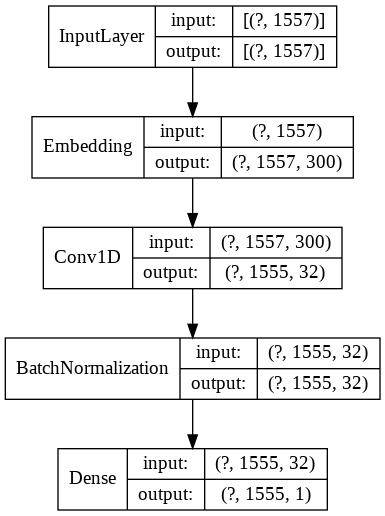

In [ ]:
model = Network()
model.summary()
plot_model(model, to_file='model-HC.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
setEpochNumber     = 5
setBatchSizeNumber = 16
csvLog = CSVLogger('logRafsanjani.csv', append=True, separator=',') # append=True --> Don't erase!

saveModel = tf.keras.callbacks.ModelCheckpoint(filepath='ModelRafsanjani',
                                               save_best_only=True,
                                               save_
                                               monitor='val_loss',
                                               mode='min',
                                               verbose=1)

In [ ]:
# help(ModelCheckpoint)
# help(CSVLogger)
# help(tf.keras.callbacks.ModelCheckpoint)

In [ ]:
results = model.fit(x=Xtrain,
                    y=Ytrain,
                    validation_data=(Xtest, Ytest),
                    epochs=setEpochNumber,
                    batch_size=setBatchSizeNumber,
                    verbose=1,
                    callbacks=[csvLog, saveModel])

Epoch 1/5
35/35 [==============================] - ETA: 0s - loss: 0.5788 - accuracy: 0.5487
Epoch 00001: val_loss improved from inf to 0.67302, saving model to ModelRafsanjani
INFO:tensorflow:Assets written to: ModelRafsanjani/assets
35/35 [==============================] - 10s 291ms/step - loss: 0.5788 - accuracy: 0.5487 - val_loss: 0.6730 - val_accuracy: 0.5542
Epoch 2/5
35/35 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.5846
Epoch 00002: val_loss did not improve from 0.67302
35/35 [==============================] - 8s 231ms/step - loss: 0.5736 - accuracy: 0.5846 - val_loss: 0.6860 - val_accuracy: 0.5545
Epoch 3/5
35/35 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.5697
Epoch 00003: val_loss did not improve from 0.67302
35/35 [==============================] - 8s 218ms/step - loss: 0.5665 - accuracy: 0.5697 - val_loss: 0.7115 - val_accuracy: 0.5546
Epoch 4/5
35/35 [==============================] - ETA: 0s - loss: 0.5796 - accurac

In [ ]:
M = tf.keras.models.load_model('ModelRafsanjani')
M

In [ ]:
results = M.fit(x=Xtrain,
                y=Ytrain,
                validation_data=(Xtest, Ytest),
                epochs=setEpochNumber,
                batch_size=setBatchSizeNumber,
                verbose=1,
                callbacks=[csvLog, saveModel], # Again epoch will continue after 5-epochs, and save the model after 5-epochs.
                )

Epoch 1/5
35/35 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.5567
Epoch 00001: val_loss did not improve from 0.67302
35/35 [==============================] - 8s 221ms/step - loss: 0.5806 - accuracy: 0.5567 - val_loss: 0.6758 - val_accuracy: 0.5539
Epoch 2/5
35/35 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.5685
Epoch 00002: val_loss did not improve from 0.67302
35/35 [==============================] - 8s 220ms/step - loss: 0.5736 - accuracy: 0.5685 - val_loss: 0.6810 - val_accuracy: 0.5542
Epoch 3/5
35/35 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.5940
Epoch 00003: val_loss did not improve from 0.67302
35/35 [==============================] - 8s 219ms/step - loss: 0.5689 - accuracy: 0.5940 - val_loss: 0.6979 - val_accuracy: 0.5532
Epoch 4/5
35/35 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.5700
Epoch 00004: val_loss did not improve from 0.67302
35/35 [========================

In [ ]:
# setEpochNumber     = 400     # Performed-welled in epoch 600.
# setBatchSizeNumber = 12


# ####################################################

# cv = KFold(n_splits=5, shuffle=True, random_state=101)

# Accuracy = []
# Sensitivity = []
# Specificity = []
# Precision = []
# MCC = []

# # ROC Curve:
# # fig1 = plt.figure(figsize=[12,12])

# TPR = []
# meanFPR = np.linspace(0, 1, 100)

# i = 1
# for train, test in cv.split(Y):

#     # Compile Model:
#     model = Network()
#     model.compile(optimizer=Adam(learning_rate=0.005),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     # Run Model:
#     results = model.fit(x=[X1[train,:,:], X2[train,:,:], X3[train,:,:]],
#                         y=Y[train,:],
#                         validation_data=([X1[test,:,:], X2[test,:,:], X3[test,:,:],], Y[test,:]),
#                         batch_size=setBatchSizeNumber, epochs=setEpochNumber,
#                         verbose=1,
#                         callbacks=[csvLogger])
    
#     accuracy = model.evaluate(x=[X1[test,:,:], X2[test,:,:], X3[test,:,:]], y=Y[test,:], batch_size=setBatchSizeNumber)
#     Accuracy.append(accuracy[1])

#     # Performance Metices:
#     Yactual = Y[test,:].argmax(axis=1)
#     Yp = model.predict([X1[test,:,:], X2[test,:,:], X3[test,:,:]])
#     v = Yp
#     Yp = Yp.argmax(axis=1)

#     CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
#     TN, FP, FN, TP = CM.ravel()

#     MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
#     Sensitivity.append( TP / (TP + FN) )
#     Specificity.append( TN / (TN + FP) )
#     Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
#     # # ROC Curve
#     # fpr, tpr, _ = roc_curve(Yactual, v[:,1])
#     # TPR.append(interp(meanFPR, fpr, tpr))
#     # rocauc = auc(fpr, tpr)
#     # plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, rocauc))
#     # i= i+1
    
#     # Performance Plot
#     print('#################################################')
#     print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
#     lossPlot(results)
#     accuracyPlot(results)
#     print('#################################################')
# #end-for

# # rocPlot(TPR, meanFPR)
# # print('Accuracy [Each Fold]: {}'.format(Accuracy))
# # print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
# # print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
# # print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
# # print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
# # print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))

Epoch 1/400
72/72 [==============================] - 1s 15ms/step - loss: 3.1755 - accuracy: 0.4942 - val_loss: 3.1108 - val_accuracy: 0.5253
Epoch 2/400
72/72 [==============================] - 1s 11ms/step - loss: 3.0372 - accuracy: 0.5278 - val_loss: 2.7820 - val_accuracy: 0.5253
Epoch 3/400
72/72 [==============================] - 1s 11ms/step - loss: 2.6002 - accuracy: 0.5324 - val_loss: 2.3474 - val_accuracy: 0.5253
Epoch 4/400
72/72 [==============================] - 1s 10ms/step - loss: 2.1285 - accuracy: 0.5440 - val_loss: 1.9227 - val_accuracy: 0.5253
Epoch 5/400
72/72 [==============================] - 1s 11ms/step - loss: 1.7543 - accuracy: 0.5336 - val_loss: 1.5771 - val_accuracy: 0.5253
Epoch 6/400
72/72 [==============================] - 1s 10ms/step - loss: 1.4546 - accuracy: 0.5370 - val_loss: 1.3648 - val_accuracy: 0.5253
Epoch 7/400
72/72 [==============================] - 1s 11ms/step - loss: 1.3090 - accuracy: 0.5509 - val_loss: 1.2968 - val_accuracy: 0.5253
Epoch 

KeyboardInterrupt: ignored